In [43]:
library(data.table)
library(mixOmics)
library(raster)
library(pracma)
library(ggpubr)

In [44]:
#Schizophrenia EWAS results for sites previously identified as associated with tobacco smoking
tobacco_schizo <- c("cg05575921",
                    "cg01940273",
                    "cg26703534",
                    "cg03636183",
                    "cg05951221",
                    "cg25952192",
                    "cg03274391",
                    "cg01772743",
                    "cg13862853",
                    "cg20566897")

In [45]:
sample_id_phase1 <- read.csv("~/Documents/data/E-GEOD-80417.sdrf.txt",sep = "\t")
sample_id_phase2 <- read.csv("~/Documents/data/E-GEOD-84727.sdrf.txt",sep = "\t")

In [46]:
phase1 <- fread("~/Documents/data/GSE80417_normalizedBetas.csv", header = T)
phase2 <- fread("~/Documents/data/GSE84727_normalisedBetas.csv", header = T)

common_probes <- intersect(phase1$V1,phase2$V1)
common_probes <- setdiff(common_probes,tobacco_schizo)


phase1 <- subset(phase1, V1 %in% common_probes)
phase2 <- subset(phase2, V1 %in% common_probes)

In [10]:
#using hannon et al probes to build a classiciation model

In [10]:
table_s3_hannon_et_al_2016 <- read.csv("~/Documents/data/schizo_data_table_s3.csv",header = T)

phase1 <- subset(phase1, V1 %in% table_s3_hannon_et_al_2016$probe_id)
phase2 <- subset(phase2, V1 %in% table_s3_hannon_et_al_2016$probe_id)


In [42]:
probe_loc <- read.csv("~/Documents/research/hm450k_annotations/hm450k_All_CoRISV.txt",header = T,stringsAsFactors = F,sep = "\t")
probe_loc = probe_loc[!duplicated(probe_loc$Prob_ID),]


In [11]:
colnames_phase1 <- phase1$V1
phase1$V1 <- NULL
phase1_t <- data.frame(t(phase1))
colnames(phase1_t) <- colnames_phase1
phase1_t$sample.id <- rownames(phase1_t)
rownames(phase1_t) <- NULL

In [12]:
colnames_phase2 <- phase2$V1
phase2$V1 <- NULL
phase2_t <- data.frame(t(phase2))
colnames(phase2_t) <- colnames_phase2
phase2_t$sample.id <- rownames(phase2_t)
rownames(phase2_t) <- NULL

In [13]:
train <- data.frame(merge(sample_id_phase1,phase1_t,by.x = "id",by.y = "sample.id"))
test <- data.frame(merge(sample_id_phase2,phase2_t,by.x = "id",by.y = "sample.id"))


In [27]:
train$id <- NULL
train$gender <- NULL
train$age <- NULL
train$status <- as.factor(ifelse(train$status==1,0,1))

In [35]:
test$sample_title <- NULL
test$gender <- NULL
test$age <- NULL
#test$status <- as.factor(ifelse(test$status==1,0,1))

In [28]:
splsda_output_beta <- mixOmics::splsda(X = subset(train,select = -c(status)),
                                        Y = train$status,ncomp = 2,keepX=c(200,200))


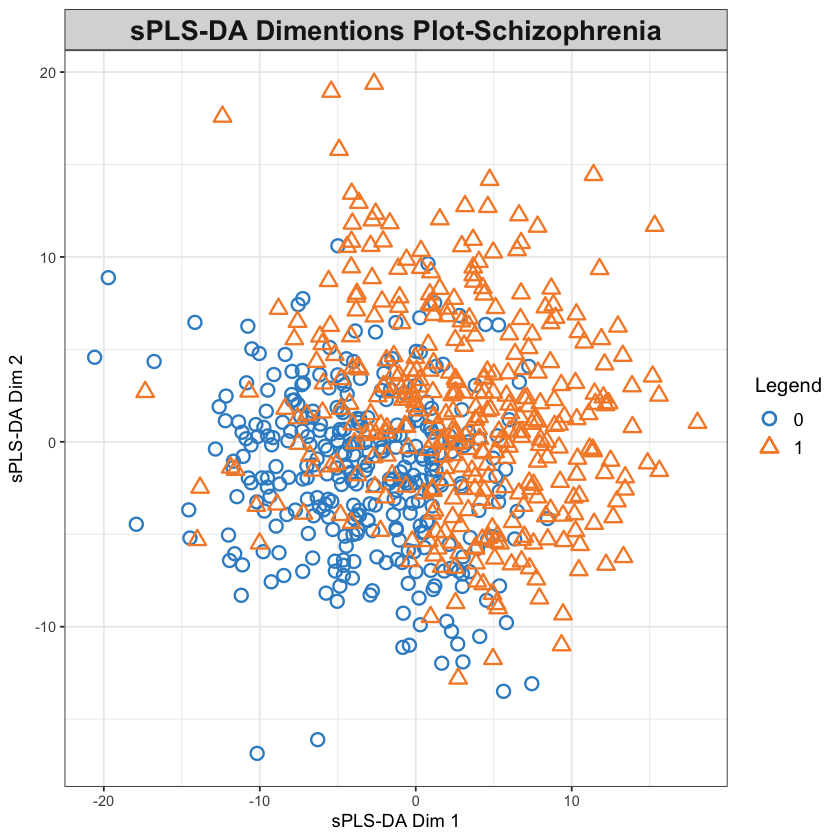

In [29]:
v <- plotIndiv(splsda_output_beta, ind.names = FALSE, legend=TRUE,
               ellipse = FALSE, star = FALSE, title = paste0('sPLS-DA Dimentions Plot-',"Schizophrenia"),
               X.label = 'sPLS-DA Dim 1', Y.label = 'sPLS-DA Dim 2',graphics.off=T)

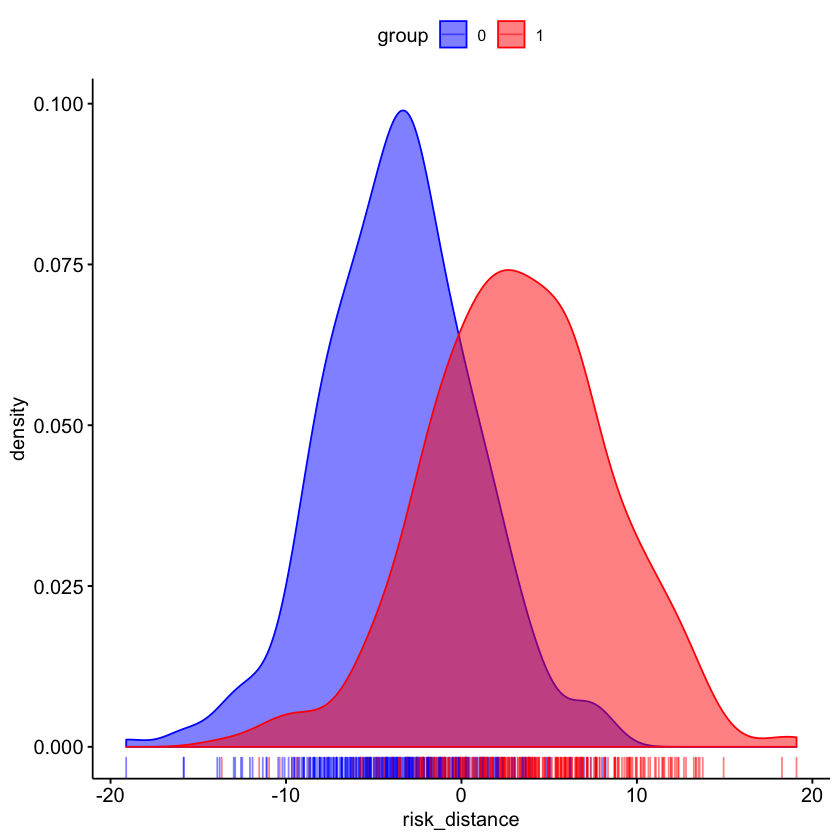

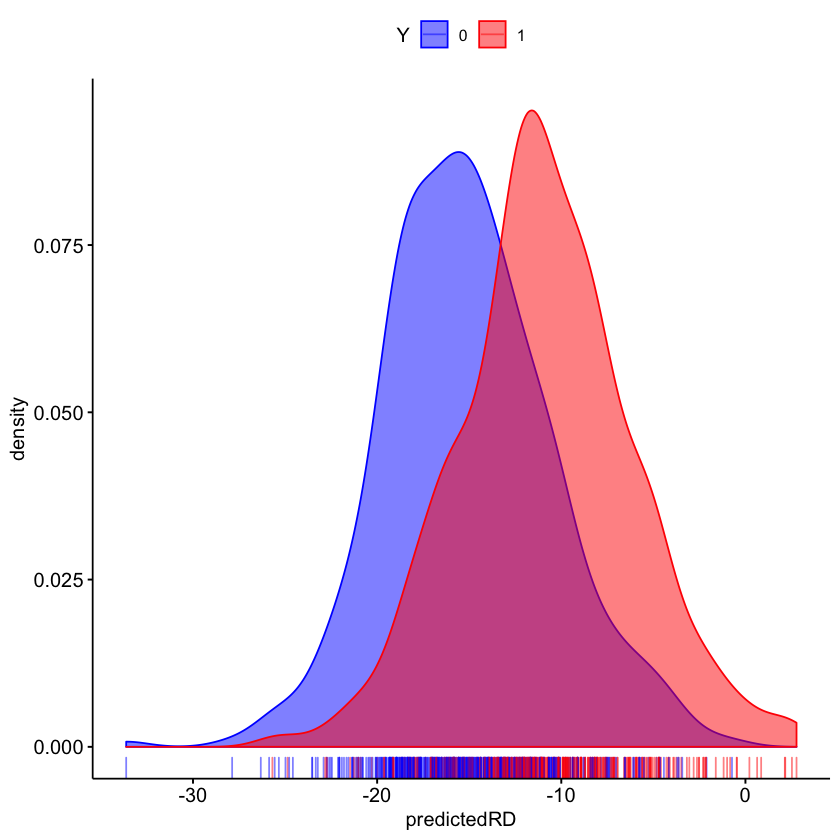

Warning message in mean.default(plot.data[plot.data$group == 0, ]$risk_distance):
“argument is not numeric or logical: returning NA”


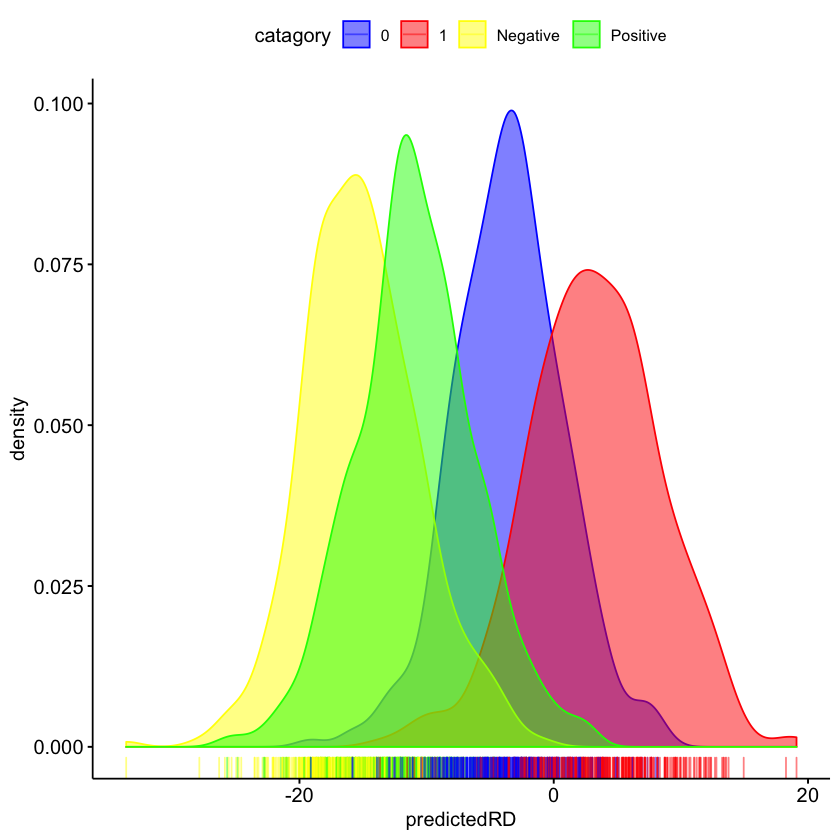

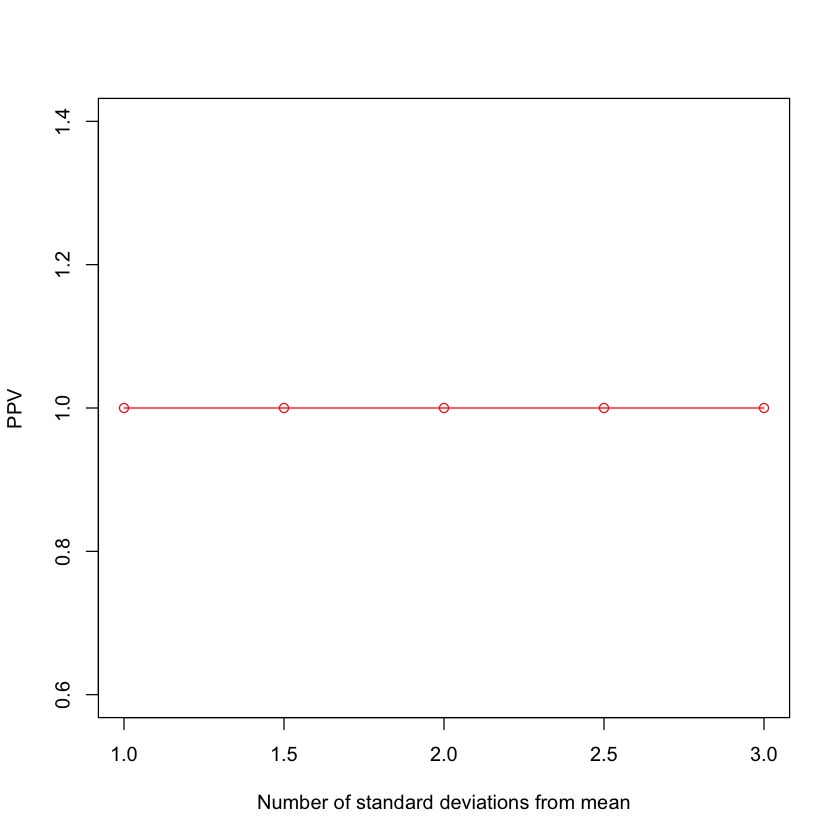

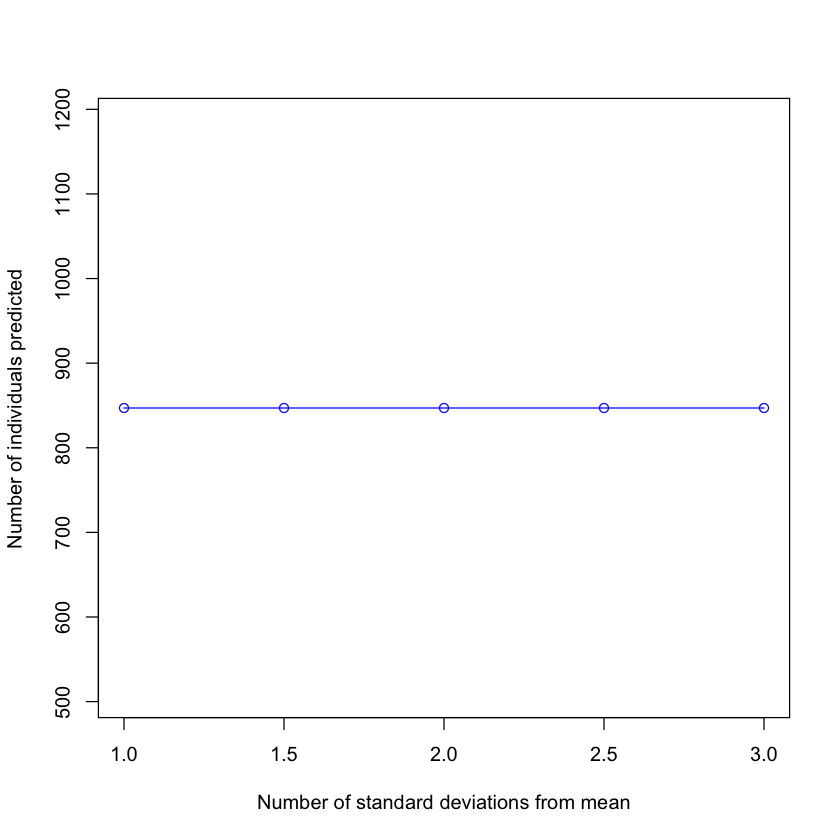

In [37]:
plsdaDF <- as.data.frame(v$df)
highest_x_y <- ceiling(max(max(abs(plsdaDF$x)),max(abs(plsdaDF$y))))
risk_distance <- function(cancer_sample){
    X <- as.numeric(cancer_sample[1])
    Y <- as.numeric(cancer_sample[2])
    d <- pointDistance(c(0,0),c(X,Y),lonlat = F)
    return(d*cos(atan2(Y,X) + deg2rad(135)))# - for MBCN + for BC
}
plsdaDF$risk_distance <- -1*apply(plsdaDF, 1, risk_distance)
plot.data <- plsdaDF[c("group","risk_distance")]
cutoff <- 2*sd(plot.data[plot.data$group==0,]$risk_distance)
ggdensity(plot.data, x = "risk_distance",
          rug = TRUE,
          color = "group", fill = "group",
          palette = c("blue", "red"))


##########################################################################
Y <- test$status
test$status <- NULL


test.predict <- predict(splsda_output_beta, test)

predicted_RD <- data.frame(-1*apply(test.predict$variates,1,risk_distance))
predicted_RD$Y <- as.numeric(as.character(Y))
colnames(predicted_RD) <- c("predictedRD","Y")

predicted_RD$Y <- as.factor(predicted_RD$Y)
ggdensity(predicted_RD, x = "predictedRD",
          rug = TRUE,
          color = "Y", fill = "Y",
          palette = c("blue", "red"))

predicted_RD$catagory <- ifelse(predicted_RD$Y==0,"Negative","Positive")
colnames(plot.data) <- c("catagory","predictedRD")

final_RD_table <- rbind(
    predicted_RD[c("predictedRD","catagory")],
    plot.data[c("predictedRD","catagory")]
)
    
ggdensity(final_RD_table, x = "predictedRD",
          rug = TRUE,
          color = "catagory", fill = "catagory",
          palette = c("blue", "red","yellow","green"))

#################################################
PPV <-c()
num_of_predicted_ind <- c()
stdev <- sd(plot.data[plot.data$group==0,]$risk_distance)#increase n
mean_PRD <- mean(plot.data[plot.data$group==0,]$risk_distance)
n_controls <- c()
n_cases <- c()


for(n in seq(1,3,0.5)){
    cutoff <- n*stdev
    cutoff <- mean_PRD + cutoff
    
    predicted_RD_cutoff <- predicted_RD[predicted_RD$predictedRD>cutoff,]
    #n_controls_in_sd <- dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==0,])[1]
    #n_cases_in_sd <- dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==1,])[1]
    predicted_RD_cutoff$predicted_Y <- as.numeric(ifelse(predicted_RD_cutoff$predictedRD>cutoff,1,0))
    
    PPV <- c(PPV,
             dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==1 & predicted_RD_cutoff$predicted_Y==1 ,])[1]/dim(predicted_RD_cutoff[predicted_RD_cutoff$predicted_Y==1 ,])[1])
    num_of_predicted_ind <- c(num_of_predicted_ind,dim(predicted_RD_cutoff)[1])
}

plot(x=seq(1,3,0.5),y=PPV,type="o",col="red",xlab="Number of standard deviations from mean")
plot(x=seq(1,3,0.5),y=num_of_predicted_ind,type="o",col="blue",xlab="Number of standard deviations from mean",ylab="Number of individuals predicted")
